# Transfer-Learning von Base-Architektur

Mit diesem Notebook haben wir untersucht, wie gut man die Basis-Architektur (trainiert für Binäre Klassifikation mit Transfer-Learning für eine Multi-Label Klassifikation anpassen können. Das Laden der Daten und der Trainings-Loop sind dabei sehr ähnlich aufgebaut. Es wird aber kein komplett neues Modell trainiert, sondern nur das Output-Layer der Base-Architektur ersetzt.

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers
from matplotlib import pyplot as plt

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
NUMBER_OF_CLASSES = 4  # Categorical Crossentropy with 4 classes

In [2]:
_data_dir = os.path.join("data", "fish_lizard_monkey_snake", "images")
TRAIN_DS, VAL_DS = keras.utils.image_dataset_from_directory(
    _data_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    interpolation="bilinear",
    pad_to_aspect_ratio=True,
    validation_split=0.2,
    subset="both",
    seed=42,
)

Found 40000 files belonging to 4 classes.
Using 32000 files for training.
Using 8000 files for validation.


In [3]:
early_stop_cb = keras.callbacks.EarlyStopping(
    min_delta=0.015,
    monitor="val_accuracy",
    mode="max",
    patience=8,
    restore_best_weights=True,
    verbose=1,
)
checkpointing_cb = keras.callbacks.ModelCheckpoint(
    "fish_lizard_monkey_snake_transfered_classifier.keras",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq="epoch",
    initial_value_threshold=None,
)
lr_cb = keras.callbacks.ReduceLROnPlateau(
    min_delta=0.015,
    monitor="val_accuracy",
    mode="max",
    patience=6,
    factor=0.5,
    min_lr=0.00001,
    verbose=1,
)
METRICS = [
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.F1Score(name="f1"),
    keras.metrics.CategoricalAccuracy(name="accuracy"),
]

In [4]:
# Load model and remove last layer. They are used for the classification
transfer_model = keras.models.load_model("bird_dog_classifier.keras")
transfer_model.pop()


# Add new output layer
transfer_model.add(layers.Dense(4, name="new_output_1"))

# Freeze all layers except the last one
for layer in transfer_model.layers:
    if "new" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False
        

transfer_model.summary()

transfer_model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=METRICS,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 224, 224, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 214,648 (838.47 KB)

 Trainable params: 1,028 (4.02 KB)

 Non-trainable params: 71,536 (279.44 KB)

 Optimizer params: 142,084 (555.02 KB)

In [5]:
transfer_history = transfer_model.fit(
    TRAIN_DS,
    validation_data=VAL_DS,
    epochs=50,
    callbacks=[early_stop_cb, checkpointing_cb, lr_cb],
)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3617 - f1: 0.3589 - loss: 1.3340 - precision: 0.3114 - recall: 0.2001
Epoch 1: val_accuracy improved from -inf to 0.43025, saving model to fish_lizard_monkey_snake_classifier.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.3617 - f1: 0.3590 - loss: 1.3339 - precision: 0.3114 - recall: 0.2001 - val_accuracy: 0.4302 - val_f1: 0.4032 - val_loss: 1.2517 - val_precision: 0.3684 - val_recall: 0.2747 - learning_rate: 0.0010
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4170 - f1: 0.4107 - loss: 1.2653 - precision: 0.3505 - recall: 0.2424
Epoch 2: val_accuracy improved from 0.43025 to 0.44050, saving model to fish_lizard_monkey_snake_classifier.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.4170 - f1: 0.4108 - loss: 1.2653 - precision: 0.3506 - recall: 0.2424 - val_accuracy: 0.4405 - val_f1: 0.4343 - val_loss: 1.2271 - val_precision: 0.3805 - val_recall: 0.3155 - learning_rate

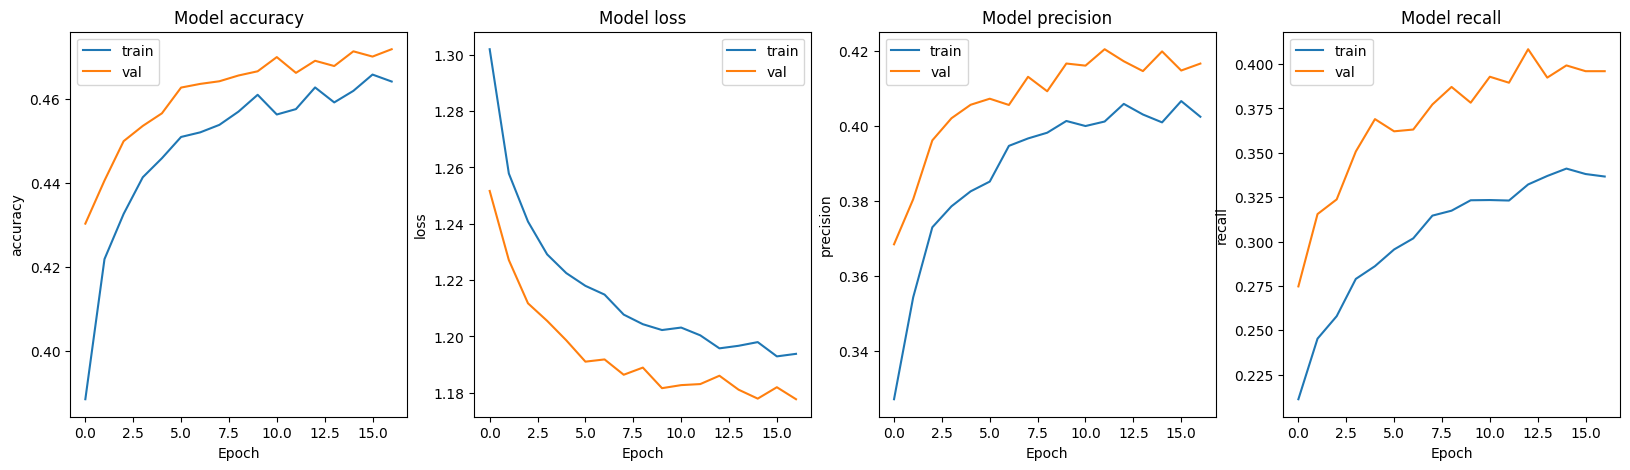

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "loss", "precision", "recall"]):
    ax[i].plot(transfer_history.history[metric])
    ax[i].plot(transfer_history.history["val_" + metric])
    ax[i].set_title(f"Model {metric}")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])